## 03 - Modelling

## Optional - Colab Setup

In [0]:
def upgrade_runtime_ram():
    meminfo = subprocess.getoutput('cat /proc/meminfo').split('\n')

    memory_info = {entry.split(':')[0]: int(entry.split(':')[1].replace(' kB','').strip()) for entry in meminfo}

    if memory_info['MemTotal'] > 17000000:
        return

    a = []
    while(1):
        a.append('1')

In [0]:
def restart_runtime():
    os.kill(os.getpid(), 9)

In [0]:
def setup_rapids():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    device_name = pynvml.nvmlDeviceGetName(handle)
    if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
        print("Wrong GPU - Restarting Runtime")
        restart_runtime()


    # clone RAPIDS AI rapidsai-csp-utils scripts repo
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git

    # install RAPIDS
    !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13


    # set necessary environment variables 
    dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
    sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
    sys.path

    # update pyarrow & modules 
    exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [0]:
def setup_conda():
    if not 'Miniconda3-4.5.4-Linux-x86_64.sh' in os.listdir():
        !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

    if not ('EPFL-Capstone-Project' in os.listdir()) and (os.getcwd().split('/')[-1] != 'EPFL-Capstone-Project'):
        !git clone https://github.com/helmigsimon/EPFL-Capstone-Project  
    if 'EPFL-Capstone-Project' in os.listdir():
        os.chdir('EPFL-Capstone-Project')

    !conda env create -f environment.yml
    !conda activate exts-ml

In [0]:
def setup_drive():
    #Mounting Google Drive
    global drive
    from google.colab import drive
    drive.mount('/content/drive')

In [6]:
try:
    import sys,os,subprocess
    
    upgrade_runtime_ram()
    setup_drive()

    #Setting up PyPi Packages
    !pip install geopandas sparse-dot-topn pdpipe category-encoders catboost
    import geopandas as gpd
    import sparse_dot_topn.sparse_dot_topn as ct
    import pdpipe as pdp
    import category_encoders

    #Setting up Conda Packages
    setup_conda()
    
    #Initializing NLTK
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    
    #Setting up RAPIDS AI
    import pynvml
    setup_rapids()
    
    from cuml import UMAP
    
except ModuleNotFoundError as e:
    print(e)
    print('Not in colab environment, continuing to run locally')
    from umap import UMAP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached https://files.pythonhosted.org/packages/83/c5/3cf9cdc39a6f2552922f79915f36b45a95b71fd343cfc51170a5b6ddb6e8/geopandas-0.7.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/cf/78/029e7781a3029e105b1ad7bc7dc878b46408186c60c21e15d1e68030331e/pdpipe-0.0.46-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a0/52/c54191ad3782de633ea3d6ee3bb2837bda0cf3bc97644bb6375cf14150a0/category_encoders-2.1.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 10.4MB 4.8MB/s 
  Using cached https://files.pythonhosted.org/packages/ec/20/4e63bc5c6e62df889297b382c3ccd4a7a488b00946aaaf81a118158c6f09/Fiona-1.8.13.post1-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 1.8MB 14.5MB/s 
    100% |████████████████████████████████| 2.1MB 15.0MB/s 
  Using cached https://files.pythonhos

NVMLError_DriverNotLoaded: ignored

## Imports

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split,  StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tqdm.pandas()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

In [0]:
from lib.transformers import *
from lib.pipelines import *
from lib.processing import save_to_pkl, load_from_pkl
from lib.visualization import GridSearchPlotter
from data.util.paths import DATA_PATH

In [0]:
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [0]:
try:
  from cuml import LinearRegression, RandomForestRegressor
except ModuleNotFoundError:
  pass

In [16]:
from catboost import CatBoostRegressor

ModuleNotFoundError: ignored

## Loading Data

In [0]:
df = load_from_pkl('final',DATA_PATH)

In [0]:
col_set = {
    'format': {
        'description': 'format_description_', 
        'name': 'format_name_', 
        'text': ('format_text_clean'),
        'quantity': ('format_quantity')
    },
    'geography': {
        'superregion': 'superregion_',
        'region': 'region_',
        'country': 'country_'
    },
    'timeperiod': {
        'period': 'period_',
        'era': 'era_'
    },
    'genre': 'genre_',
    'style': 'style_',
    'null': None,
    'indicator': lambda x: x.max() == 1 and x.min() == 0,
    'image_embedding': 'image_umap_'
}
column_store = ColumnStore()
column_store.fit(df,col_set)

## Preparing for Machine Learning

In [0]:
X_tr, X_te, y_tr, y_te = train_test_split(df.drop('market_value',axis=1),df.market_value)

In [0]:
df_sample = pd.concat([X_tr,y_tr],axis=1).sample(frac=0.1)
X_tr_sample = df_sample.drop('market_value',axis=1)
y_tr_sample = df_sample['market_value']

In [0]:
del df

## Setting up Dummy Regression for baseline

In [0]:
dummy_regressor = DummyRegressor(strategy='mean')

In [17]:
dummy_regressor.fit(X_tr,np.log(y_tr).values)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [0]:
dummy_pred = dummy_regressor.predict(X_te)

In [20]:
r2_score(y_te,np.exp(dummy_pred))

-0.07814059006227048

In [21]:
mean_absolute_error(y_te,np.exp(dummy_pred))

10.514016596942366

Ridge Regression

In [0]:
full_information_transformer = ColumnTransformer(transformers=[
    ('units_for_sale_imputer', SimpleImputer(strategy='constant',fill_value=0),['units_for_sale']),
    ('average_rating_imputer', SimpleImputer(strategy='mean'),['average_rating']),
    ('year_encoder', OneHotEncoder(dtype=np.uint8), ['year'])
], remainder='passthrough')

In [0]:
record_store_lr_transformer = ColumnTransformer(transformers=[
    ('year_encoder', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['year'])
], remainder='passthrough')

In [0]:
record_store_lr_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title',
    ]

In [0]:
record_store_lr_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id','format_name'])),
    ('record_store_column_remover', ColumnRemover(record_store_lr_removal_columns)),
    ('preprocessing',record_store_lr_transformer),
    ('scaler', StandardScaler()),
    ('lr', GridSearchCV(
        LinearRegression(),
        param_grid={
            'normalize':[False,True]
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
    ))
])

In [27]:
record_store_lr_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   19.7s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.1s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('running_time_imputer',
                 RunningTimeImputer(number_of_tracks='number_of_tracks',
                                    running_time='running_time')),
                ('leave_one_out_encoding',
                 LeaveOneOutEncoder(cols=['artist', 'label', 'format_text',
                                          'master_id', 'format_name'],
                                    drop_invariant=False,
                                    handle_missing='value',
                                    handle_unknown='value', random_state=None,
                                    return_df=True, sigm...
                              estimator=LinearRegression(algorithm='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7fd24b818190>, verbose=False, output_type='input'),
                              iid='deprecated', n_jobs=-1,
                              param_grid={'normalize': [False, True]},
           

In [28]:
record_store_lr_pipe['lr'].best_score_

-1.1308526660036766

In [29]:
lr_pred = record_store_lr_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [30]:
r2_score(y_te,np.exp(lr_pred))

-1.339171995805663e+111

In [31]:
mean_absolute_error(y_te,np.exp(lr_pred))

2.7449847925524948e+54

In [18]:
from cuml import Ridge

ModuleNotFoundError: ignored

In [0]:
record_store_ridge_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id'])),
    ('record_store_column_remover', ColumnRemover(record_store_lr_removal_columns)),
    ('preprocessing',record_store_lr_transformer),
    ('scaler', StandardScaler()),
    ('ridge', GridSearchCV(
        Ridge(normalize=False,solver='eig'),
        param_grid={
            'alpha': np.linspace(1e-2,1e3,20),
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
        return_train_score=True
    ))
])

In [39]:
record_store_ridge_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('running_time_imputer',
                 RunningTimeImputer(number_of_tracks='number_of_tracks',
                                    running_time='running_time')),
                ('leave_one_out_encoding',
                 LeaveOneOutEncoder(cols=['artist', 'label', 'format_text',
                                          'format_name', 'master_id'],
                                    drop_invariant=False,
                                    handle_missing='value',
                                    handle_unknown='value', random_state=None,
                                    return_df=True, sigm...
       2.10534211e+02, 2.63165263e+02, 3.15796316e+02, 3.68427368e+02,
       4.21058421e+02, 4.73689474e+02, 5.26320526e+02, 5.78951579e+02,
       6.31582632e+02, 6.84213684e+02, 7.36844737e+02, 7.89475789e+02,
       8.42106842e+02, 8.94737895e+02, 9.47368947e+02, 1.00000000e+03])},
                              pre_dispatch='2*n_jobs', refit=Tr

In [0]:
plotter = GridSearchPlotter(record_store_ridge_pipe['ridge'])

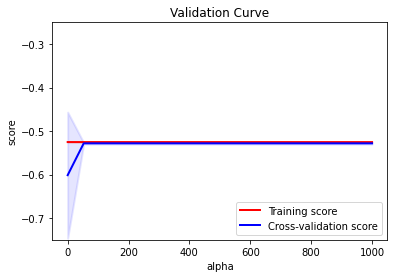

In [47]:
plotter.plot_validation_curve(parameter='alpha',ylim=(-0.75,-0.25))

In [45]:
record_store_ridge_pipe['ridge'].best_score_

-0.5281733252425947

In [40]:
record_store_ridge_pipe['ridge'].best_params_

{'alpha': 315.7963157894737}

In [48]:
ridge_pred = record_store_ridge_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [50]:
r2_score(y_te,np.exp(ridge_pred))

0.17161807292869136

In [51]:
mean_absolute_error(y_te,np.exp(ridge_pred))

8.508850500505012

## Random Forest

In [0]:
record_store_random_forest_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title'
    ]
record_store_random_forest_removal_columns.extend(
    column_store._indicator
)

In [0]:
full_information_transformer = ColumnTransformer(transformers=[
    ('units_for_sale_imputer', SimpleImputer(strategy='constant',fill_value=0),['units_for_sale']),
    ('average_rating_imputer', SimpleImputer(strategy='mean'),['average_rating']),
    ('year_encoder', OneHotEncoder(dtype=np.uint8), ['year'])
], remainder='passthrough')

In [16]:
from cuml import RandomForestRegressor

ModuleNotFoundError: ignored

In [107]:
random_forest_preprocessing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id'])),
    ('reduce_indicators', IndicatorReducer(indicators=column_store._indicator,algorithm=UMAP,components=40)),
    ('record_store_column_remover', ColumnRemover(record_store_random_forest_removal_columns)),
    ('cast_to_32', FunctionTransformer(func=lambda x: x.values.astype(np.float32)))
])

random_forest = RandomForestRegressor(
      seed=0,
      rows_sample=0.1,
      n_estimators=100,
      n_bins=25,
      split_criterion=2,
      max_depth=20,
      max_features='auto',
      min_rows_per_node=2,
      min_impurity_decrease=0
  )

random_forest_search_pipe = Pipeline([
    ('preprocessing',random_forest_preprocessing_pipe),
    ('grid_search', GridSearchCV(
        random_forest,
        cv=KFold(n_splits=5,shuffle=True),
        param_grid={
        },
        verbose=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        return_train_score=True
    ))
])

random_forest_pipe = Pipeline([
    ('preprocessing',random_forest_preprocessing_pipe),
    ('random_forest',random_forest)
])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Setting the random seed does not fully guarantee the exact same results at this time.


In [101]:
random_forest_search_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.2s


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.4min
[Paralle

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown=...
                              estimator=RandomForestRegressor(n_estimators=100, max_depth=

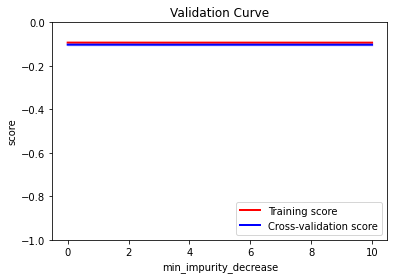

In [102]:
random_forest_plotter = GridSearchPlotter(random_forest_search_pipe['grid_search'])
random_forest_plotter.plot_validation_curve(parameter='min_impurity_decrease',ylim=(-1,0))

In [105]:
random_forest_search_pipe['grid_search'].best_score_

-0.10215552896261215

In [106]:
random_forest_search_pipe['grid_search'].best_params_

{'min_impurity_decrease': 0}

In [108]:
random_forest_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown=...
                 RandomForestRegressor(n_estimators=100, max_depth=20, handle=<cuml.common

In [109]:
random_forest_tr_pred = random_forest_pipe.predict(X_tr)
random_forest_te_pred = random_forest_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [110]:
mean_absolute_error(np.log(y_tr),random_forest_tr_pred)

0.6910381797919923

In [112]:
r2_score(y_tr,np.exp(random_forest_tr_pred))

-0.08569952062358754

In [113]:
r2_score(y_te,np.exp(random_forest_te_pred))

-0.08699321858477127

In [114]:
mean_absolute_error(y_tr,np.exp(random_forest_tr_pred))

10.468069197895579

In [115]:
mean_absolute_error(y_te,np.exp(random_forest_te_pred))

10.451856799756252

## Catboost

    100% |████████████████████████████████| 64.8MB 400kB/s 
    100% |████████████████████████████████| 26.1MB 974kB/s 
    100% |████████████████████████████████| 10.0MB 5.8MB/s 
    100% |████████████████████████████████| 7.2MB 1.1MB/s 
    100% |████████████████████████████████| 20.2MB 2.5MB/s 
    100% |████████████████████████████████| 12.4MB 2.1MB/s 
    100% |████████████████████████████████| 512kB 13.0MB/s 
    100% |████████████████████████████████| 235kB 24.2MB/s 
    100% |████████████████████████████████| 71kB 27.6MB/s 
    100% |████████████████████████████████| 92kB 35.0MB/s 
  Running setup.py bdist_wheel for retrying ... done
  Stored in directory: /root/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


ModuleNotFoundError: ignored

In [0]:
record_store_catboost_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title'
    ]
record_store_catboost_removal_columns.extend(
    column_store._indicator
)

In [0]:
catboost_param_grid = {
        'depth': np.linspace(1,16,5).astype(int),
        'learning_rate' : np.logspace(-4,-1,5),
        'l2_leaf_reg': np.linspace(1,50,5).astype(int),
        'iterations': np.linspace(50,250,3),
        'n_estimators': np.linspace(20,200,5).astype(int)
}

In [0]:
catboost_grid_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('reduce_indicators', IndicatorReducer(indicators=column_store._indicator-column_store._geography,algorithm=UMAP,components=40)),
    ('record_store_column_remover', ColumnRemover(record_store_catboost_removal_columns)),   
    ('grid_search', GridSearchCV(
        CatBoostRegressor(
            random_seed=0,
            cat_features=['year','format_text','master_id','format_name','artist','label','country'],
            one_hot_max_size=25,
            boosting_type='Ordered',          
        ),
        param_grid={'depth': np.linspace(1,16,5).astype(int)},
        n_jobs=1,
        scoring='neg_mean_absolute_error',
        verbose=5)
    )
])

In [0]:
catboost_grid_pipe.fit(X_tr_sample,np.log(y_tr_sample))

In [0]:
catboost_plot = GridSearchPlotter(catboost_pipe['grid_search'])
catboost_plot.plot_validation_curve(parameter='depth')

In [0]:
catboost_pipe.best_score_

In [0]:
catboost_pipe.best_params_

In [0]:
catboost_pred = catboost_pipe.predict(X_te)

In [0]:
r2_score(y_te,np.exp(catboost_pred))

In [0]:
mean_absolute_error(y_te,np.exp(catboost_pred))